# Objected Detection ( PyTorch )
![](https://drive.google.com/uc?export=view&id=12BDNHM7OowvaK8qfvEh4oJsm1auLHzlP)

## 移動 Colab 所在位置

In [1]:
import os 
path = '/content/drive/My Drive/人生KPI/工作坊/1091120_NQU_AI'
os.chdir(path)
print('Move to WorkSpace : ', path)

Move to WorkSpace :  /content/drive/My Drive/人生KPI/工作坊/1091120_NQU_AI


## 輸入圖片以及前處理


torch.Size([1, 3, 315, 600])


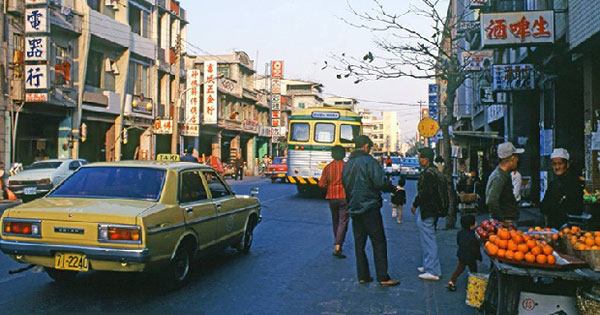

In [2]:
from PIL import Image
from torchvision import datasets, transforms as T
from IPython.display import display
import cv2

# 導入圖片資料
img_path = 'images/obj_image.jpg'
src_img = cv2.imread(img_path)  # 待會用來畫圖用的
img_pil = Image.open(img_path)

# 這邊只要轉成 tensor 即可
trans = T.Compose([T.ToTensor()])

# 增加一維，滿足模型輸入格式 ( batch_size, channel, width, height )
img_tensor = trans(img_pil).unsqueeze(0)
print(img_tensor.size())

# 顯示圖片
display(img_pil)

## 副函式 :　取得數據集、取得隨機顏色

In [3]:
import numpy as np

def coco_dataset():

  COCO_INSTANCE_CATEGORY_NAMES = [
      '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
      'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
      'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
      'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
      'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
      'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
      'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
      'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
      'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
      'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
      'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
      'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
  ]
  #print("COCO's TOTAL CLASSES: ", len(COCO_INSTANCE_CATEGORY_NAMES))
  return COCO_INSTANCE_CATEGORY_NAMES

def random_color():

  r = np.random.randint(0, 255)
  g = np.random.randint(0, 255)
  b = np.random.randint(0, 255)
  return (r,g,b)

## 主要運作的部分

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



person : 8
orange : 1
car : 2
traffic light : 1
bus : 1


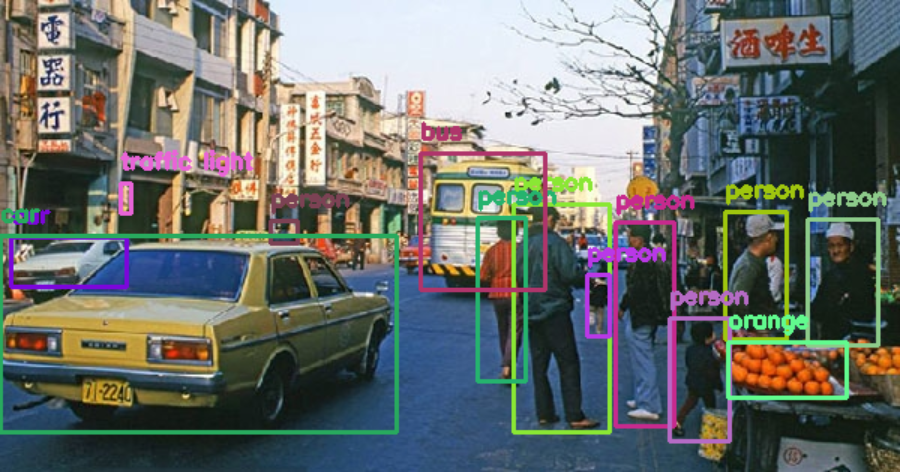

Cost time: 8.205772638320923s


In [4]:
import torch
from torch import nn
import numpy as np
from collections import Counter
import torchvision
import time

# 參數
threshold = 0.8
out_scale = 1.5

# 取得數據集
COCO = coco_dataset()

# 導入 物件辨識的 預訓練 模型
trg_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 模型跟資料都丟進GPU，將模型設定成 eval 驗證模式
if torch.cuda.is_available():
  trg_model.cuda().eval()
  img_tensor = img_tensor.cuda()
else:
  trg_model.eval()

# 計算時間 
start = time.time()

# 防止倒傳遞
with torch.no_grad():
  
  # 進行預測，會獲得一個字典 { 'boxes':__ , 'labels':__ , 'scores':__ }
  predict = trg_model(img_tensor)
  boxes = predict[0]['boxes']
  labels = predict[0]['labels'] 
  scores = predict[0]['scores'] 

  labels_count = [] # 用來放信心分數大於 ___ 的物件

  for idx in range(boxes.shape[0]):

    # 當AI辨識物件的信心指數大於___才進行框選
    if scores[idx] >= threshold:

      # 取得 Bounding Box 之座標位置
      x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
      
      # 取得對應的標籤 arg idx
      name = COCO[labels[idx]]

      # 用於 計算總數 以及 隨機顏色
      labels_count.append(name)
      color = random_color()
      
      # 畫方形 ( 來源， 左上， 右下， 顏色， 寬度)
      cv2.rectangle(src_img,(x1,y1),(x2,y2), color, 2)
      
      # 填文字 ( 來源， 內容， 左上， 類型， 縮放， 粗細，)
      cv2.putText(src_img, text=name, org=(x1, y1-10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
          fontScale=0.5, color=color, thickness=2)


# 計算框出來的物件 此處的 items 是 Counter 函數的
for k,v in Counter(labels_count).items():
  print(f"{k} : {v}")

end = time.time()

# 將圖片放大顯示
resize = cv2.resize( src_img, ( int(src_img.shape[1]*out_scale), int(src_img.shape[0]*out_scale)) )
from google.colab.patches import cv2_imshow
cv2_imshow(resize)

print(f"Cost time: {end-start}s")